# Day-26: ROC Curve, AUC-ROC, and PR Curve Deep Dive

## Topics Covered:

 
- Model Evaluation Recap: Accuracy, F1, ROC-AUC, PR Curve
- Comparing Models: Logistic Regression, Decision Tree, Naive Bayes, KNN
- Visualization: ROC Curves, PR Curves
- Dataset: Kaggle Retail Dataset (Sales/Customer churn-like setup)


#### **1. Accuracy: The Deceptive Metric**

As we learned on Day 14, **Accuracy** is the proportion of correct predictions. While intuitive, it can be highly misleading in datasets with a significant class imbalance.





**Example:** In our retail dataset, imagine 90% of reviews are positive. A simple model that always predicts "positive" would achieve 90% accuracy, yet it completely fails to identify any negative reviews. This is where other metrics become essential to get a true picture of performance.



#### **2. ROC Curve and AUC-ROC: The Full Picture**



The **ROC Curve** plots the **True Positive Rate (TPR)** against the **False Positive Rate (FPR)** at different classification thresholds. This visualization shows a model's performance across its entire range of sensitivity and specificity. The **Area Under the Curve (AUC)** provides a single number summarizing this performance; an AUC of 1.0 is perfect, while 0.5 is no better than random guessing.

- **TPR (Recall):** Out of all actual positives, what proportion did the model correctly identify?
- **FPR:** Out of all actual negatives, what proportion did the model incorrectly identify as positive?

By plotting the ROC curve, you can visually compare how well different models separate the two classes. A model with a curve that hugs the top-left corner is superior, as it achieves a high TPR with a low FPR. 


### 🛠️ Use Case: Retail Product Sentiment Analysis

Let's use a retail review dataset to classify customer sentiment as 'positive' or 'negative'. This is a common business use case, and the data is often imbalanced, with far more positive reviews than negative ones. We'll compare a Logistic Regression model with a k-Nearest Neighbors (k-NN) model.

In [2]:
! pip install seaborn matplotlib scikit-learn pandas numpy

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)


--- Model Accuracy ---
Logistic Regression Accuracy: 0.8740
k-NN Accuracy: 0.8257

--- Logistic Regression Classification Report ---
              precision    recall  f1-score   support

           0       0.80      0.60      0.68      1558
           1       0.89      0.96      0.92      5235

    accuracy                           0.87      6793
   macro avg       0.85      0.78      0.80      6793
weighted avg       0.87      0.87      0.87      6793


--- k-NN Classification Report ---
              precision    recall  f1-score   support

           0       0.68      0.45      0.54      1558
           1       0.85      0.94      0.89      5235

    accuracy                           0.83      6793
   macro avg       0.77      0.69      0.72      6793
weighted avg       0.81      0.83      0.81      6793



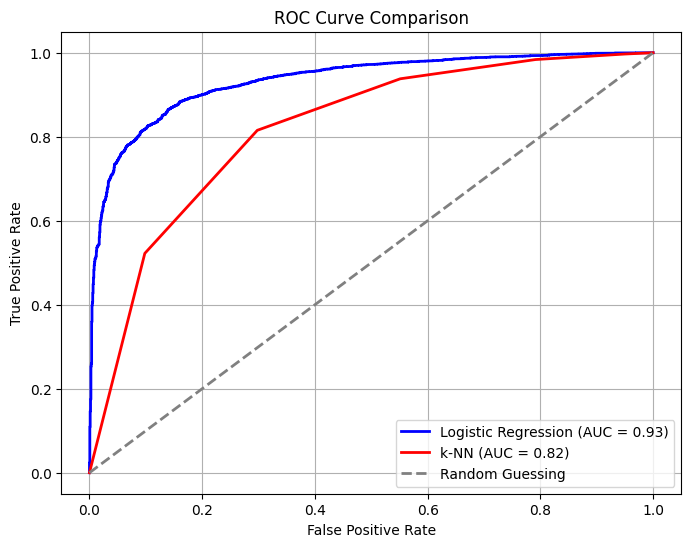

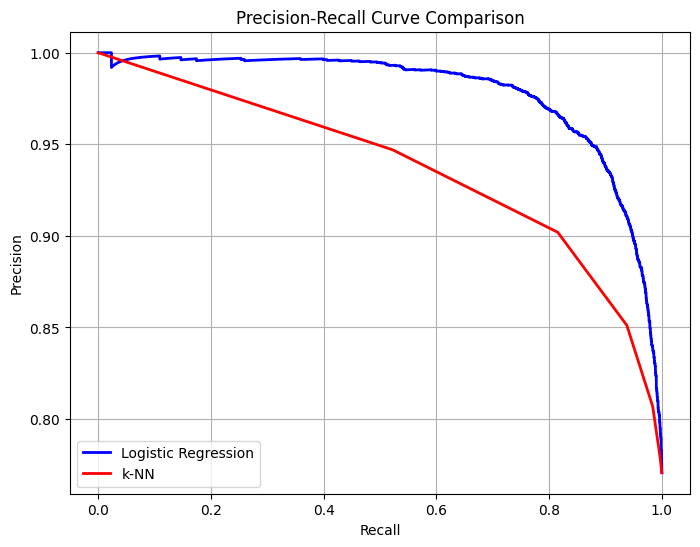

In [1]:

# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset (replace with your specific dataset path)
# We'll use a hypothetical retail review dataset for this example.
try:
    df = pd.read_csv('Womens Clothing E-Commerce Reviews.csv')
except FileNotFoundError:
    print("Dataset not found. Please download from Kaggle or use a local path.")
    # For demonstration, let's create a dummy DataFrame
    data = {
        'Review Text': ['Great product, love it!', 'Terrible quality, never again.', 'Fits well, very happy.', 'Slightly disappointed, but okay.', 'The worst I have ever bought.', 'Exactly what I wanted, perfect!', 'Awful, broke after one use.'],
        'Rating': [5, 1, 4, 3, 1, 5, 2]
    }
    df = pd.DataFrame(data)

# Preprocessing: Create a binary target variable
df['sentiment'] = df['Rating'].apply(lambda x: 1 if x > 3 else 0)

# Drop any rows with missing review text
df.dropna(subset=['Review Text'], inplace=True)

# Split the data
X = df['Review Text']
y = df['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Feature Engineering: Convert text to numerical features using TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Initialize models
log_reg_model = LogisticRegression(random_state=42)
knn_model = KNeighborsClassifier(n_neighbors=5) # We covered k-NN on Day 22

# Train the models
log_reg_model.fit(X_train_tfidf, y_train)
knn_model.fit(X_train_tfidf, y_train)

# Predict probabilities and classes
log_reg_probs = log_reg_model.predict_proba(X_test_tfidf)[:, 1]
knn_probs = knn_model.predict_proba(X_test_tfidf)[:, 1]
log_reg_preds = log_reg_model.predict(X_test_tfidf)
knn_preds = knn_model.predict(X_test_tfidf)

# --- Performance Evaluation ---

print("--- Model Accuracy ---")
print(f"Logistic Regression Accuracy: {accuracy_score(y_test, log_reg_preds):.4f}")
print(f"k-NN Accuracy: {accuracy_score(y_test, knn_preds):.4f}")

# Classification Report (Precision, Recall, F1-score)
print("\n--- Logistic Regression Classification Report ---")
print(classification_report(y_test, log_reg_preds))

print("\n--- k-NN Classification Report ---")
print(classification_report(y_test, knn_preds))

# ROC Curve & AUC
fpr_lr, tpr_lr, _ = roc_curve(y_test, log_reg_probs)
roc_auc_lr = auc(fpr_lr, tpr_lr)

fpr_knn, tpr_knn, _ = roc_curve(y_test, knn_probs)
roc_auc_knn = auc(fpr_knn, tpr_knn)

plt.figure(figsize=(8, 6))
plt.plot(fpr_lr, tpr_lr, color='blue', lw=2, label=f'Logistic Regression (AUC = {roc_auc_lr:.2f})')
plt.plot(fpr_knn, tpr_knn, color='red', lw=2, label=f'k-NN (AUC = {roc_auc_knn:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Precision-Recall Curve
precision_lr, recall_lr, _ = precision_recall_curve(y_test, log_reg_probs)
precision_knn, recall_knn, _ = precision_recall_curve(y_test, knn_probs)

plt.figure(figsize=(8, 6))
plt.plot(recall_lr, precision_lr, color='blue', lw=2, label='Logistic Regression')
plt.plot(recall_knn, precision_knn, color='red', lw=2, label='k-NN')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve Comparison')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()